In [38]:
# Cell 1: Don't Edit This Cell
# --------------------------------------------------------------------------------------------------
# Import Libraries and Load Data
# --------------------------------------------------------------------------------------------------

import os
import sys

# Set path to project root (one level up from notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import from your src module
from src.data_loader import load_train_data, load_test_data

# Standard libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and test data using your cleaned loader
X_train, y_train = load_train_data(path='../data/train.csv')
X_test = load_test_data(path='../data/test.csv')

# Ensure outputs/figures directory exists
os.makedirs("../outputs/figures", exist_ok=True)

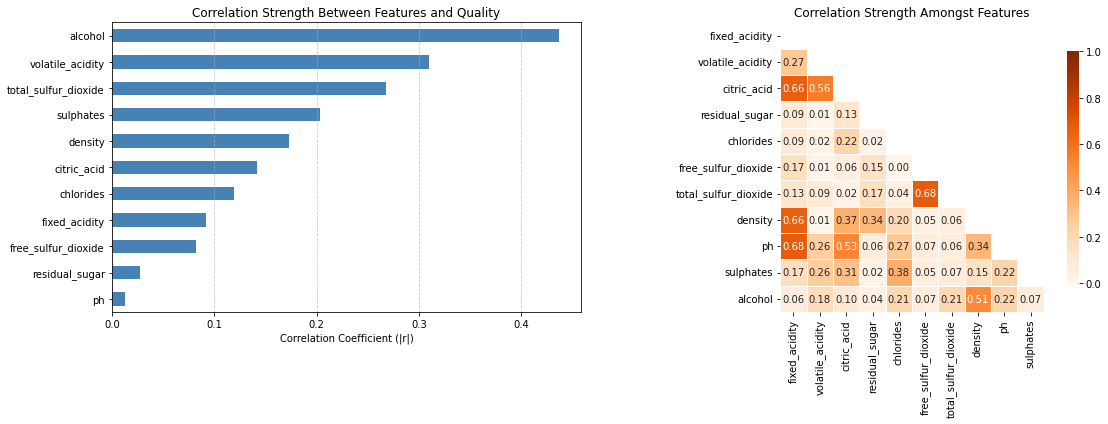

In [39]:
# Cell 2: Slightly Edited This Cell 
# --------------------------------------------------------------------------------------------------

# Basic Exploratory Data Analysis (EDA):
# Review the correlation strength between each predictor and the response (quality) using the bar chart
# Review the correlation strength between each pair of features using the correlation matrix heat map

# --------------------------------------------------------------------------------------------------

# Reconstruct a full training DataFrame for correlation purposes
train_df = X_train.copy()
train_df["quality"] = y_train

# Compute correlation of predictors with 'quality'
correlations = train_df.corr()['quality'].drop('quality')


# Compute absolute correlation matrix amongst predictors
corr_matrix = X_train.corr().abs()

# Create a mask for the upper triangle
full_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask_df = pd.DataFrame(full_mask, index=corr_matrix.index, columns=corr_matrix.columns)

# Drop 'id' and/or other unwanted columns if present
corr_matrix = corr_matrix.drop(index='id', columns='alcohol', errors='ignore')
mask_df = mask_df.drop(index='id', columns='alcohol', errors='ignore')

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of correlations with quality
correlations.abs().sort_values().plot(kind='barh', color='steelblue', ax=ax1)
ax1.set_title('Correlation Strength Between Features and Quality')
ax1.set_xlabel('Correlation Coefficient (|r|)')
ax1.grid(True, axis='x', linestyle='--', alpha=0.7)

# Heatmap of absolute correlation matrix (lower triangle only)
sns.heatmap(corr_matrix, mask=mask_df, annot=True, fmt=".2f", cmap="Oranges",
            vmin=0, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax2)
ax2.set_title('Correlation Strength Amongst Features')

plt.tight_layout()
plt.savefig("../outputs/figures/correlation_matrix_sc.png", dpi=300)
plt.show()


# 🔍 Key Observations from the Correlation Matrix

## TL;DR
- **Left plot** (bar chart): Shows how strongly each feature correlates with the target variable `quality`.
- **Right plot** (heatmap): Shows how strongly features correlate with *each other* (not with the target).

---

### 📈 Feature vs. Target (`quality`)

Correlation values range from **−1** (perfect inverse) to **+1** (perfect positive).  
The closer to ±1, the more *predictive* the feature is of `quality`.

- **`alcohol`** has the strongest positive correlation with `quality` (**+0.44**):  
  → Higher alcohol content tends to mean higher-quality wine.
- **`volatile_acidity`** is moderately *negatively* correlated (**−0.31**):  
  → Higher acidity is associated with lower perceived quality.
- **`total_sulfur_dioxide`** (**−0.27**) and **`density`** (**−0.17**) also show negative correlations.
- **`sulphates`** (**+0.20**) and **`citric_acid`** (**+0.14**) show mild positive correlations.

---

### ⚠️ Feature vs. Feature (Multicollinearity Watch)

We're on the lookout for **feature pairs with high correlation**.  
When two features overlap significantly, consider removing the one with the *lower* absolute correlation to `quality`.

- **`free_sulfur_dioxide`** and **`total_sulfur_dioxide`** (**+0.68**)  
  → Strong overlap — may introduce multicollinearity.
- **`density`** and **`residual_sugar`** (**+0.53**)  
  → Potential redundancy.
- **`fixed_acidity`** and **`citric_acid`** (**+0.56**)  
  → Moderate correlation — consider selecting one.
- **`pH`** shows weak correlation with *everything* —  
  → Unlikely to add value, and was likely dropped during preprocessing.

---



In [40]:
# Cell 2.1: Identify and Recommend Features for Modeling
# --------------------------------------------------------------------------------------------------

# Automatically select features with absolute correlation > 0.1 to 'quality'
# and display which features are included vs excluded based on this threshold.
# Also provide inline comments showing correlation values.

# --------------------------------------------------------------------------------------------------

from IPython.display import display, Markdown

threshold = 0.1

# Recalculate correlations using clean data
full_df = X_train.copy()
full_df['quality'] = y_train
correlations = full_df.corr()['quality'].drop('quality')

selected_corr = correlations[correlations.abs() > threshold].sort_values(ascending=False)
excluded_corr = correlations[correlations.abs() <= threshold].sort_values(ascending=False)

# Display selected features
md_selected = "### ✅ Features selected for modeling (|correlation| > 0.1):\n"
for feature, corr in selected_corr.items():
    md_selected += f"- `{feature}` → **r = {corr:.3f}**\n"

# Display excluded features
md_excluded = "\n### ⚠️ Features excluded (|correlation| ≤ 0.1):\n"
for feature, corr in excluded_corr.items():
    md_excluded += f"- `{feature}` → r = {corr:.3f}\n"

# Display suggested features block
md_snippet = "\n### Paste this into Cell 3:\n```python\nselected_features = [\n"
for feature, corr in selected_corr.items():
    md_snippet += f"    '{feature}',  # r = {corr:.3f}\n"
md_snippet += "]\n```"

# Output to notebook
display(Markdown(md_selected))
display(Markdown(md_excluded))
display(Markdown(md_snippet))

### ✅ Features selected for modeling (|correlation| > 0.1):
- `alcohol` → **r = 0.437**
- `sulphates` → **r = 0.203**
- `citric_acid` → **r = 0.142**
- `chlorides` → **r = -0.119**
- `density` → **r = -0.173**
- `total_sulfur_dioxide` → **r = -0.267**
- `volatile_acidity` → **r = -0.310**



### ⚠️ Features excluded (|correlation| ≤ 0.1):
- `fixed_acidity` → r = 0.092
- `ph` → r = 0.013
- `residual_sugar` → r = -0.027
- `free_sulfur_dioxide` → r = -0.083



### Paste this into Cell 3:
```python
selected_features = [
    'alcohol',  # r = 0.437
    'sulphates',  # r = 0.203
    'citric_acid',  # r = 0.142
    'chlorides',  # r = -0.119
    'density',  # r = -0.173
    'total_sulfur_dioxide',  # r = -0.267
    'volatile_acidity',  # r = -0.310
]
```

In [58]:
# Cell 3: Edit This Cell
# --------------------------------------------------------------------------------------------------

# Edit the list 'selected_features' to include only the features you want included in the model
# Type a '#' to the left of any features you want to remove.
# Consider using the above visuals to decide which you want to include:
#   - In general, it's good to include features that correlate highly with the response (quality)
#   - In general, it's not good to include 2 or more features that correlate highly with each other, 
#     even if they all individually correlate with the response.

# Note: 'id' values are unique and arbitrarily assigned. Any correlation with the response is spurious.
# 'id' is typically not included in modeling, but feel free to experiment.

# --------------------------------------------------------------------------------------------------

# Original List of Features:
# selected_features = [
#     # 'id',
#     'fixed_acidity',
#     'volatile_acidity',
#     'citric_acid',
#     'residual_sugar',
#     'chlorides',
#     'free_sulfur_dioxide',
#     'total_sulfur_dioxide',
#     'density',
#     'ph',
#     'sulphates',
#     'alcohol'
# ]

selected_features = [
    'alcohol',  # r = 0.437
    'sulphates',  # r = 0.203
    'citric_acid',  # r = 0.142
    'chlorides',  # r = -0.119
    'density',  # r = -0.173
    'total_sulfur_dioxide',  # r = -0.267
    'volatile_acidity',  # r = -0.310
]

In [59]:
# Cell 4: Don't Edit This Cell
# --------------------------------------------------------------------------------------------------

# Create train and test feature sets that only include the selected features

# --------------------------------------------------------------------------------------------------

X_train_selected = X_train[selected_features]
X_test_ids = X_test['id']
X_test_selected = X_test[selected_features]

In [60]:
# Cell 5: Don't Edit This Cell
# --------------------------------------------------------------------------------------------------

# Train a logistic regression model using the training data responses and the selected features

# --------------------------------------------------------------------------------------------------

model = LogisticRegression(max_iter=1000)
model.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000)

In [62]:
# Cell 6: Edit This Cell
# --------------------------------------------------------------------------------------------------

# Edit the variable 'threshold' with a classification threshold.  The logistic regression model calculates the probability that a given wine is 1 (Good).
    # If this probability is greater than the threshold, it will be classified as 1 (Good)
    # If this probability is less than the threshold, it will be classified as 0 (Bad)

# --------------------------------------------------------------------------------------------------

threshold = 0.75

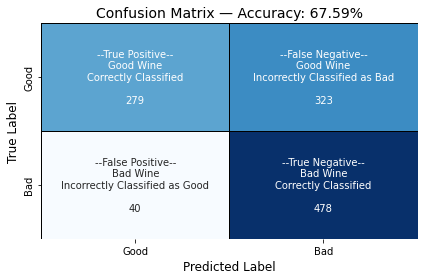

In [63]:
# Cell 7: Don't Edit This Cell
# --------------------------------------------------------------------------------------------------

# Evaluate your model's performance with a confusion matrix.
# It compares the true quality of every wine in the training data, with your model's prediction.
# The overall accuracy of the model is in the title of the matrix.
# Note, submission scores will typically be a lower than the accuracy exhibited by your training data.
# Consider experimenting with different features in cell 3 and different thresholds in cell 6, and observe how the performance changes.

# --------------------------------------------------------------------------------------------------

# Predictions
train_probability_predictions = model.predict_proba(X_train_selected)[:, 1]
train_class_predictions = [1 if x >= threshold else 0 for x in train_probability_predictions]

# Confusion matrix and accuracy
cm = confusion_matrix(y_train, train_class_predictions, labels=[1, 0])
acc = accuracy_score(y_train, train_class_predictions)

# Labels for heatmap
annot_labels = np.array([
    [f"--True Positive--\nGood Wine\nCorrectly Classified\n\n{cm[0,0]}",
     f"--False Negative--\nGood Wine\nIncorrectly Classified as Bad\n\n{cm[0,1]}"],
    [f"--False Positive--\nBad Wine\nIncorrectly Classified as Good\n\n{cm[1,0]}",
     f"--True Negative--\nBad Wine\nCorrectly Classified\n\n{cm[1,1]}"]
])

# Create smaller figure
plt.figure(figsize=(6, 4))  # smaller overall footprint

# Plot with black borders
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"],
            annot_kws={"fontsize": 10},
            linecolor='black', linewidths=1)  # black cell borders

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title(f"Confusion Matrix — Accuracy: {acc:.2%}", fontsize=14)
plt.tight_layout()

# Save the figure to ../outputs/figures/
plt.savefig("../outputs/figures/confusion_matrix.png", dpi=300)

plt.show()

### Confusion Matrix Breakdown

|                       | **Predicted Good** | **Predicted Bad** |
|-----------------------|--------------------|-------------------|
| **Actual Good**       | ✅ TP = 279         | ❌ FN = 323        |
| **Actual Bad**        | ❌ FP = 40          | ✅ TN = 478        |

---

### 🔍 What This Means

- ✅ **True Positives (279)**: These are wines correctly identified as **Good**.
- ✅ **True Negatives (478)**: These are wines correctly identified as **Bad**.
- ❌ **False Positives (40)**: These are **Bad** wines incorrectly predicted as **Good**.
- ❌ **False Negatives (323)**: These are **Good** wines incorrectly predicted as **Bad**.

---

### Observations

- **False Negatives are the big problem.**
- We're missing **323 good wines**, which is a lot!
- This suggests the model is too *conservative* — it's more likely to predict a wine as **Bad** unless it’s very confident.
- Why? Probably the **classification threshold** (currently `threshold = 0.75`) is tuned for **precision**, not **recall**.

---

### Should We Be Worried?

I mean...yikes, it's not great, but...:

- This is **baseline logistic regression**, using only a few hand-selected features.
- We're training on **imbalanced data** — and the model might be favoring the more frequent class (**Bad** wines).
- This result is on **training data**, and the model is generalizing fairly well by avoiding **false positives** (which are often more damaging in real-world settings).

---

### What We Could Try Next

- **Tune the threshold** in Cell 6:
  - Try lowering it to `0.4`, `0.35`, etc. to recover more **Good** wines.
  - Track how **accuracy**, **false negatives**, and **false positives** shift.

- **Add back or engineer new features**:
  - Maybe `ph`, `residual_sugar`, or a nonlinear combo helps.

- **Try a different model**:
  - Logistic regression is linear. Consider:
    - `RandomForestClassifier`
    - `GradientBoostingClassifier`
    - `XGBoost` (for final leaderboard submission)


In [50]:
# Cell 7.1: Show Sigmoid Equation with Coefficients
# --------------------------------------------------------------------------------------------------
# Display the learned logistic regression equation:
#   p̂ = 1 / (1 + exp(-(β₀ + β₁·x₁ + β₂·x₂ + ... + βₙ·xₙ)))

feature_names = X_train_selected.columns
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Format the equation nicely
equation = f"p̂ = 1 / (1 + exp(-({intercept:.4f}"
for coef, name in zip(coefficients, feature_names):
    sign = '+' if coef >= 0 else '-'
    equation += f" {sign} {abs(coef):.4f}·{name}"
equation += ")))"

# Print it
print("Logistic Regression Sigmoid Equation:")
print(equation)


Logistic Regression Sigmoid Equation:
p̂ = 1 / (1 + exp(-(-8.2560 + 0.9157·alcohol + 1.9936·sulphates - 0.4171·citric_acid - 1.3908·chlorides + 0.0097·density - 0.0152·total_sulfur_dioxide - 2.7515·volatile_acidity)))


## Logistic Regression Equation (Sigmoid)

The logistic regression model estimates the probability (**p̂**) that a given wine is **Good** (quality = 1), based on a linear combination of selected features. It uses the **sigmoid function** to map any real-valued number into a probability between 0 and 1.

### Equation

\[
\hat{p} = \frac{1}{1 + e^{-z}} \quad \text{where } z = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n
\]

Substituting in our model’s coefficients:

\[
\hat{p} = \frac{1}{1 + e^{-(-8.2560 + 0.9157 \cdot \text{alcohol} + 1.9936 \cdot \text{sulphates} - 0.4171 \cdot \text{citric\_acid} - 1.3908 \cdot \text{chlorides} + 0.0097 \cdot \text{density} - 0.0152 \cdot \text{total\_sulfur\_dioxide} - 2.7515 \cdot \text{volatile\_acidity})}
\]

### Interpretation of Coefficients

Each coefficient (\(\beta_i\)) represents the **log-odds change** in the probability of a wine being classified as "Good" for a **1-unit increase** in the corresponding feature, **holding other features constant**.

- **Positive coefficients** (like `alcohol` +0.9157, `sulphates` +1.9936): increase the likelihood that a wine is classified as Good.
- **Negative coefficients** (like `volatile_acidity` −2.7515, `chlorides` −1.3908): decrease the likelihood of a Good classification.
- **Intercept (−8.2560)**: shifts the sigmoid curve left or right — it reflects the baseline log-odds before any features are considered.

### Why p̂ versus ŷ?
#### Or more than likely you didn't ask that and I'm adding it for my own re-edification!

- \(\hat{p}\) is the **predicted probability** from the sigmoid function.
- \(\hat{y}\) is the **final predicted class**, computed by applying a threshold (e.g., 0.5) to \(\hat{p}\).
- We use \(\hat{p}\) to allow **threshold tuning**, which can trade off between recall and precision depending on our goals.

---

In [48]:
# Cell 8: Don't Edit This Cell
# --------------------------------------------------------------------------------------------------

# Use your model to calculate predictions for the wines in the test data, and create a submission file.

# --------------------------------------------------------------------------------------------------

# Calculate predictions for test records
test_probability_predictions = model.predict_proba(X_test_selected)[:,1]
test_class_predictions = [1 if x >= threshold else 0 for x in test_probability_predictions]

# Combine record id and predictions into one dataframe
submission = pd.DataFrame()
submission['id'] = X_test_ids
submission['quality'] = test_class_predictions

# Output predictions to a csv for submission
submission.to_csv('submission.csv', index=False)